# Using the image cutout tool with DP0.2

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">
<br>
Contact author: Christina Williams <br>
Last verified to run: 2024-04-30 <br>
LSST Science Piplines version: Weekly 2024_16 <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** This notebook demonstrates how to use the Rubin Image Cutout Service.

**Skills:** Run the Rubin Image Cutout Service for visual inspection of small cutouts of LSST images.

**LSST Data Products:** Images (deepCoadd, calexp), catalogs (objectTable, diaObject, truthTables, ivoa.ObsCore).

**Packages:** PyVO, lsst.rsp.get_tap_service, lsst.pipe.tasks.registerImage, lsst.afw.display

**Credit:**
This notebook builds on technical exploration of the cutout service developed by Leanne Guy (in preparation), and builds on an earlier notebook written by Alex Drlica-Wagner <a href="https://github.com/rubin-dp0/cst-dev/blob/main/ADW_gravelpit/TAP_Image_Access.ipynb">linked here</a>. This notebook additionally includes contributed functions by Jeff Carlin and Ryan Lau for time-variable sources. 

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook will teach how to use the cutout service (which enables users to retrieve small image cutouts from LSST data) by demonstration of a few basic science applications. Since LSST images are quite large, in some cases it is desirable to be able to perform operations (e.g. image cutouts) on the server side to avoid transferring large amounts of data. This can speed up visual inspection and other analyses requiring images of individual objects or fields that may be much smaller than the patch and tract sizes that are created by the LSST camera and pipelines.

The <a href="https://www.ivoa.net/">International Virtual Observatory Alliance (IVOA)</a> provides a <a href="https://www.ivoa.net/documents/SODA/20170517/REC-SODA-1.0.html">Server-side Operations for Data Access (SODA)</a> for web data access. The LSST architecture is built to fit into the requirements of the Virtual Observatory, enabling the use of Virtual Observatory tools such as the image cutout service to access LSST data. The procedure is to identify the remote web location of the image of interest (called a datalink), and use a web service that creates a cutout from that linked data remotely, to transfer and save locally on the Rubin Science Platform.

Further demonstration of the technical side of this process using DP0.2 data can be found in (Leanne's companion tutorial when published, link here). Further details and information can be found at <a href="https://www.ivoa.net/documents/DataLink/20211115/WD-DataLink-1.1-20211115.html"> the IVOA data link documentation</a>, where it says Access Data Services. Rubin-specific documentation for these can also be found in <a href="https://dmtn-238.lsst.io/">this document describing the RSP DataLink service implementation strategy</a>. 



### 1.1 Package Imports


In [1]:
# Import general python packages
import time
import numpy as np
import uuid
import os
import glob
import math

# LSST package imports
import lsst.geom as geom
import lsst.resources
import lsst.afw.display as afwDisplay
from lsst.afw.image import Exposure, ExposureF

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service
from lsst.rsp.utils import get_access_token

# Packages for warping and aligning calexp cutouts
from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask

# Pandas tools for working with tables
import pandas

# Plotting functions
import matplotlib.pyplot as plt

# PyVO packages
import pyvo
from pyvo.dal.adhoc import DatalinkResults, SodaQuery

# Astropy
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.io import fits
from astropy.wcs import WCS

from PIL import Image
from IPython.display import Image as dimg


### 1.2 Define Functions and Parameters


#### 1.2.1 Set up  plotting defaults for matplotlib.

In [2]:
# Set up some plotting defaults
params = {'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 12,
          'xtick.major.width': 2,
          'xtick.minor.width': 1,
          'xtick.major.size': 10,
          'xtick.minor.size': 4,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 2,
          'axes.linewidth': 2,
          'axes.labelweight': 2,
          'axes.titleweight': 2,
          'ytick.major.width': 2,
          'ytick.minor.width': 1,
          'ytick.major.size': 10,
          'ytick.minor.size': 4,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [6, 6],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

# Set afw display backend to matplotlib
afwDisplay.setDefaultBackend('matplotlib')

# Set the maximum number of rows to display from pandas
pandas.set_option('display.max_rows', 20)

plt.style.use('tableau-colorblind10')


#### 1.2.2 Create some environment variables

This next cell creates a new temporary folder in the home directory called "temp". The cutout tool must first save cutouts as fits files locally on the Rubin Science Platform (RSP) so this notebook will save those files in temp. At the end of the notebook, the last cell will clear the contents and remove the temp folder.

In [3]:
homeDir = os.getenv("HOME")
tempdir = homeDir+'/temp'
if not os.path.exists(tempdir):
    os.makedirs(tempdir)


#### 1.2.3 Define functions for manipulating image cutouts and plotting

The following cells define a number of functions to be used throughout the tutorial. The first function is to enable easy plotting of files from the cutout tool (plotImage). The next function, `make_image_cutout', is a wrapper function that will perform the operations needed to call the cutout tool and create image cutouts stored locally. This procedure will first be demonstrated in Section 2. The steps include: 1) define the location on the sky. 2) Query the TAP service for the specifications of the dataId. 3) Retrieve the datalink URL associated with the data. 4) Create a cutout instance from the query result and the Datalink Resource.

In [4]:
def plotImage(exposure: ExposureF):
    """Plot and image using lsst.awf.image package

   Parameters
    ----------
    exposure : `ExposureF`
        the image to plot from file in LSST awf image exposure class format

   Returns
    -------
    image for notebook display
    """

    fig, ax = plt.subplots()
    display = afwDisplay.Display(frame=fig)
    display.scale('asinh', 'zscale')
    display.mtv(exposure.image)
    plt.show()


In [5]:
def make_image_cutout(tap_service, ra, dec, dataId, cutout_size=0.01,
                      imtype=None, filename=None):
    """Wrapper function to generate a cutout using the cutout tool

   Parameters
    ----------
    tap_service : an instance of the TAP service
    ra, dec : 'float'
        the ra and dec of the cutout center
    dataId : 'dict'
        the dataId of the image to make a cutout from. The format
        must correspond to that provided for parameter 'imtype'
    cutout_size : 'float', optional
        edge length in degrees of the cutout
    imtype : 'string', optional
        string containing the type of LSST image to generate
        a cutout of (e.g. deepCoadd, calexp). If imtype=None,
        the function will assume a deepCoadd.
    filename : 'string', optional
        filename of the resulting cutout (which has fits format)

   Returns
    -------
    sodaCutout : 'string'
        filename of the cutout in fits format (including
        full directory path; for now by default it is saved
        in /home/temp/
    """

    spherePoint = geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)

    if imtype == 'calexp':

        query = "SELECT access_format, access_url, dataproduct_subtype, " + \
            "lsst_visit, lsst_detector, lsst_band, s_ra, s_dec " + \
            "FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
            "AND obs_collection = 'LSST.DP02' " + \
            "AND dataproduct_subtype = 'lsst.calexp' " + \
            "AND lsst_visit = " + str(dataId["visit"]) + " " + \
            "AND lsst_detector = " + str(dataId["detector"])
        results = tap_service.search(query)

    else:
        # Find the tract and patch that contain this point
        tract = dataId["tract"]
        patch = dataId["patch"]

        # add optional default band if it is not contained in the dataId
        band = dataId["band"]

        query = "SELECT access_format, access_url, dataproduct_subtype, " + \
            "lsst_patch, lsst_tract, lsst_band, s_ra, s_dec " + \
            "FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
            "AND obs_collection = 'LSST.DP02' " + \
            "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
            "AND lsst_tract = " + str(tract) + " " + \
            "AND lsst_patch = " + str(patch) + " " + \
            "AND lsst_band = " + "'" + str(band) + "' "
        results = tap_service.search(query)

    # Get datalink
    dataLinkUrl = results[0].getdataurl()
    auth_session = service._session
    dl = DatalinkResults.from_result_url(dataLinkUrl,
                                         session=auth_session)

    # from_resource: creates a instance from
    # a number of records and a Datalink Resource.
    sq = SodaQuery.from_resource(dl,
                                 dl.get_adhocservice_by_id("cutout-sync"),
                                 session=auth_session)

    sq.circle = (spherePoint.getRa().asDegrees() * u.deg,
                 spherePoint.getDec().asDegrees() * u.deg,
                 cutout_size * u.deg)

    if filename:
        sodaCutout = os.path.join(os.getenv('HOME'), 'temp/'+filename)
    else:
        sodaCutout = os.path.join(os.getenv('HOME'), 'temp/soda-cutout.fits')

    with open(sodaCutout, 'bw') as f:
        f.write(sq.execute_stream().read())

    return sodaCutout

Finally, this third cell below defines a set of functions that we will use to work with cutouts of the same source to demonstrate how to visualize variability between calexp files, for diaObjects. Since calexp files may be imaged at any orientation on the sky, in order to align the images the user will 1) rotate and scale the image to a common grid (`warp_image`) and 2) determine the bounding box of the cutouts (`get_minmax_xy`) and 3) create a gif of those warped images to visualize the variability of the source (`make_gif`). These will be demonstrated in Section 4.

In [6]:
def warp_img(ref_img, img_to_warp, ref_wcs, wcs_to_warp):
    """Warp and rotate an image onto the coordinate system of another image

   Parameters
    ----------
    ref_img: 'ExposureF'
        is the reference image for the re-projection
    img_to_warp: 'ExposureF'
        the image to rotate and warp onto the reference image's wcs
    ref_wcs: 'wcs object'
        the wcs of the reference image (i.e. ref_img.getWcs() )
    wcs_to_warp: 'wcs object'
        the wcs of the image to warp (i.e. img_to_warp.getWcs() )
   Returns
    -------
    warpedExp: 'ExposureF'
        a reprojected, rotated image that is aligned and matched to ref_image
     """
    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp


def get_minmax_xy(img, cutout_size):
    """Get the pixel dimensions of an image

   Parameters
    ----------
    img: 'ExposureF'
        is the input image to return the pixel coordinates of
    cutout_size: 'int'
        is the edge size of the image in pixels
   Returns
    -------
    minx, maxx, miny, maxy: 'int'
        the min and max x and y pixel coordinates for the input image
     """

    cutout_size = int(cutout_size)

    height = img.height
    width = img.width

    ceny = (height - 1) / 2
    cenx = (width - 1) / 2

    minx = int(cenx - ((cutout_size - 1) / 2))
    maxx = int(cenx + ((cutout_size - 1) / 2))
    miny = int(ceny - ((cutout_size - 1) / 2))
    maxy = int(ceny + ((cutout_size - 1) / 2))

    return {'minx': minx, 'maxx': maxx, 'miny': miny, 'maxy': maxy}


def make_gif(folder):
    """Generate a GIF for all *.png images contained in a folder

   Parameters
    ----------
    # folder: 'string'
        string containing the path to the folder
        default filename is animation.gif

   Returns
    -------
     """
    frames = [Image.open(img) for img in sorted(glob.glob(f"{folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save(folder+"/animation.gif", format="GIF",
                   append_images=frames, save_all=True, duration=500, loop=1)


## 2. A step by step demonstration of how to use the Rubin Image Cutout Service

This section will demonstrate a simple example: how to create a cutout for a single object from a deepCoadd. 


### 2.1 Initiate the TAP service, and define sky coordinates for the image cutout

The TAP service is used to query the ivoa.Obscore table for the datalink (a web URL identifying where the data is hosted).

In [7]:
service = get_tap_service("tap")

First, define a point on the sky as the center of the image cutout. This example uses the galaxy cluster from DP0.2 Notebook Tutorial 03a. Once the RA and Dec are defined, we will create a SpherePoint class to define the location on the sky, that is then used to identify which Patch and Tract contains that location among the deepCoadd images.  

In [8]:
ra = 55.7467
dec = -32.2862
coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
radius = .1 * u.deg

spherePoint = lsst.geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)

query = "SELECT s_ra, s_dec, lsst_patch, lsst_tract, s_region " + \
        "FROM ivoa.ObsCore " + \
        "WHERE dataproduct_type = 'image' " + \
        "AND obs_collection = 'LSST.DP02' " + \
        "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
        "AND CONTAINS(POINT('ICRS', " + str(coord.ra.value) + \
        ", " + str(coord.dec.value) + "), " + \
        "s_region) = 1"

results = service.search(query)

tract = results['lsst_tract'][0]
patch = results['lsst_patch'][0]

# check datalab tutorials for more info about SODA

The identified Patch and Tract will be used to define the unique dataId for that location, and once a filter (band) is included, this defines a unique deepCoadd in the LSST image database. 

In [9]:
dataId = {'band': 'i', 'tract': tract,
          'patch': patch}

The next cell shows the query to the TAP service for the metadata that is associated with the image's remote location in the LSST data archive. The DP0.2 has a schema (table collection) called "ivoa", which contains a table called ivoa.ObsCore. The IVOA-defined obscore table contains generic metadata for the DP0.2 datasets. The table is accessible via ADQL queries via a TAP endpoint. The mechanism for locating images from observations is to use the TAP service to query the ObsCore schema. 

In [10]:

query = "SELECT access_format, access_url, dataproduct_subtype, " + \
    "lsst_patch, lsst_tract, lsst_band, s_ra, s_dec  " + \
    "FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
    "AND obs_collection = 'LSST.DP02' " + \
    "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
    "AND lsst_tract = " + str(tract) + " " + \
    "AND lsst_patch = " + str(patch) + " " + \
    "AND lsst_band = 'i' "

results = service.search(query)
results.to_table().show_in_notebook()

idx,access_format,access_url,dataproduct_subtype,lsst_patch,lsst_tract,lsst_band,s_ra,s_dec
,,,,,,,deg,deg
0,application/x-votable+xml;content=datalink,https://data-int.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/20d28216-534a-4102-b8a7-1c7f32a9b78c,lsst.deepCoadd_calexp,17,4431,i,55.65214108466622,-32.205663176664345


In the above table, the access_url contains the web URL datalink for the requested deepCoadd. This datalink will be needed to generate the image cutout.

### 2.2 Generating an image cutout 

First, extract the datalink (`dataLinkUrl`) from the query result using the `getdataurl` method. Next, extract the session authentication, which is needed for reuse of the datalink (see DP0.2 Tutorial 22a, which has further technical explanation). Finally, create a `DatalinkResults` object to be able to access this URL, which will be stored as `dl_results` and available for approximately 15 minutes, in a format that can be used by the IVOA tools below.


In [11]:
dataLinkUrl = results[0].getdataurl()

auth_session = service._session
dl_results = DatalinkResults.from_result_url(dataLinkUrl,
                                             session=auth_session)

f"Datalink status: {dl_results.status}. Datalink service url: {dataLinkUrl}"

"Datalink status: ('OK', 'QUERY_STATUS not specified'). Datalink service url: https://data-int.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/20d28216-534a-4102-b8a7-1c7f32a9b78c"

Lastly, call the Rubin Image Cutout Service. It is done by feeding the data link created above (called `dl_results`) to following function:

In [12]:
sq = SodaQuery.from_resource(dl_results,
                             dl_results.get_adhocservice_by_id("cutout-sync"),
                             session=auth_session)


The variable `sq` now holds the result of the SODA query using the data link (which currently still points the full LSST patch and tract deepCoadd image, at its remote location in the database). The cell below will now demonstrate how to extract a cutout from `sq`.  

### 2.2.1 Defining a square cutout using a subtended circle

Only 2 shape definitions are supported: a circle function, and a polygon function can be used to define the cutout dimensions. These shape definitions do not produce circle or polygon cutouts, but rather are methods for defining the edges of cutouts with 4 sides. In the case of circle, the resulting cutout is always a square, with edge size that is the same as the circle diameter. In the case of a polygon, either a square or a rectanglar cutout will result, depending on whether the length and width edge dimensions are different values. Only cutouts with 4 corners and 90 degree angles are supported. 

The output of the cutout service is (currently) limited to a fits file stored in the returned Google cloud storage service (GCS) bucket. Thus, while the image cutout procedure itself is performed remotely, the cutout must be written to disk first before it is accessed by the notebook (which is done using the write() function). (Future planned options for the Rubin cutout service, including the potential to retrieve other image formats such as jpeg, are listed at the <a href="https://dmtn-208.lsst.io/">Rubin Science Platform image cutout implementation strategy document</a>).

All cutouts will be stored in the $HOME/temp folder. Finally, call the plotImage function (defined above), which will quickly display the cutout that was written to disk in in the temp folder.

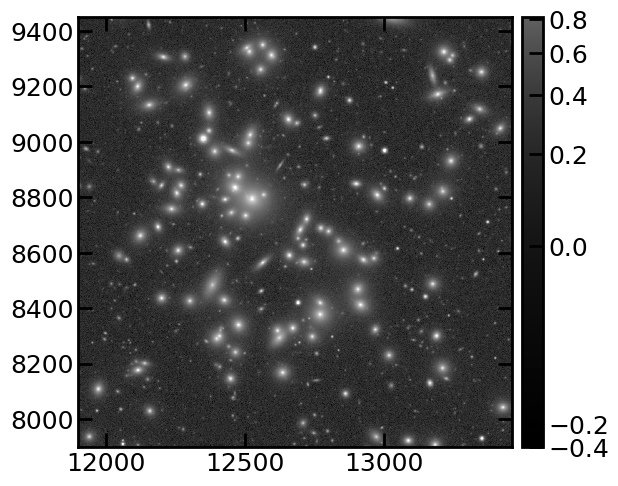

In [13]:
sphereRadius = 0.05 * u.deg

sq.circle = (spherePoint.getRa().asDegrees() * u.deg,
             spherePoint.getDec().asDegrees() * u.deg,
             sphereRadius)

# first write the file to disk:
sodaCutout = os.path.join(os.getenv('HOME'), 'temp/soda-cutout-circle.fits')
with open(sodaCutout, 'bw') as f:
    f.write(sq.execute_stream().read())

# Display the cutout from the file
plotImage(ExposureF(sodaCutout))


### 2.2.2 Using polygon to define the image cutout shape instead of a circle

It is also possible to define the cutout geometry using a polygon, which enables the cutout to be rectangular, but not necessarily be square. For this, use `polygon`, which takes as input the four corners in celestial coordinates. A minimum of 3 vertices are required (the line from the last vertex back to the first is implicit) Vertices must be ordered in the counter-clockwise direction. For example: a polygon is defined as a set of 4 (x,y) coordinates from (12,34) to (14,34) to (14,36) to (12,36) and (implicitly) back to (12,34) as:

POLYGON=12 34 14 34 14 36 12 36

Since the center of the galaxy cluster is already defined in RA and Dec in the cells above (`spherePoint`), this example will define each x,y set as RA+/-sphereRadius and Dec+/-sphereRadius. 

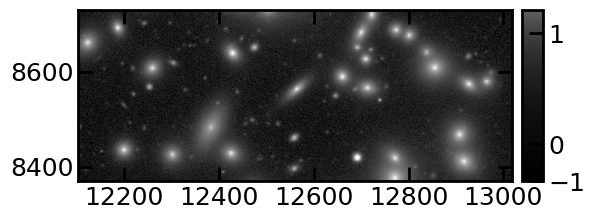

In [14]:
sq2 = SodaQuery.from_resource(dl_results,
                              dl_results.get_adhocservice_by_id("cutout-sync"),
                              session=auth_session)
sphereRadius1 = 0.03 * u.deg
sphereRadius2 = 0.01 * u.deg

sq2.polygon = (spherePoint.getRa().asDegrees() * u.deg - sphereRadius1,
               spherePoint.getDec().asDegrees() * u.deg - sphereRadius2,
               spherePoint.getRa().asDegrees() * u.deg - sphereRadius1,
               spherePoint.getDec().asDegrees() * u.deg + sphereRadius2,
               spherePoint.getRa().asDegrees() * u.deg + sphereRadius1,
               spherePoint.getDec().asDegrees() * u.deg + sphereRadius2)
#               spherePoint.getRa().asDegrees()* u.deg + sphereRadius2,
#               spherePoint.getDec().asDegrees()*u.deg - sphereRadius2)

sodaCutout2 = os.path.join(os.getenv('HOME'), 'temp/soda-cutout-polygon.fits')
with open(sodaCutout2, 'bw') as f:
    f.write(sq2.execute_stream().read())

plotImage(ExposureF(sodaCutout2))



There is an important difference to note between the circle and polygon shape definitions. The angular distance on the sky that defines the circular cutout size already accounts for the difference in angular distance in the RA direction is smaller by a factor of cos(declination), where declination is in units radians. The difference increases with higher declination. However, the polygon definition does not automatically account for this cosine factor. Thus, circle and polygon cutout definitions using the same cutout edge length will not match size in the RA direction (for deepCoadds, the x-axis). The cell below demonstrates how to make this correction to the polygon cutout definition to create symmetric cutouts with polygon. Here sphereRadius comes from the circle definition above.

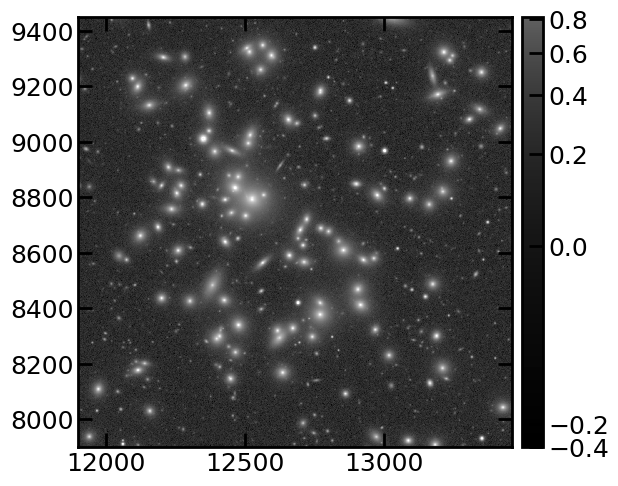

In [15]:
a = Angle(spherePoint.getDec().asDegrees(), u.deg)
cosd = np.cos(a.radian)

sq2.polygon = (spherePoint.getRa().asDegrees() * u.deg - sphereRadius/cosd,
               spherePoint.getDec().asDegrees() * u.deg - sphereRadius,
               spherePoint.getRa().asDegrees() * u.deg - sphereRadius/cosd,
               spherePoint.getDec().asDegrees() * u.deg + sphereRadius,
               spherePoint.getRa().asDegrees() * u.deg + sphereRadius/cosd,
               spherePoint.getDec().asDegrees() * u.deg + sphereRadius,
               spherePoint.getRa().asDegrees() * u.deg + sphereRadius/cosd,
               spherePoint.getDec().asDegrees() * u.deg - sphereRadius)

sodaCutout2 = os.path.join(os.getenv('HOME'), 'temp/soda-cutout_polygon.fits')
with open(sodaCutout2, 'bw') as f:
    f.write(sq2.execute_stream().read())

plotImage(ExposureF(sodaCutout2))


### 2.3 Test out the cutout wrapper function "make_image_cutout" 

All of the above steps from section 2.2 have been compiled in a wrapper function called `make_image_cutout` that is defined in Section 1. In the rest of this notebook, cutouts will be generated using this function for simplicity. As defined, it assumes the circular cutout definition demonstrated above. Thus, the function requires as input the TAP service, the center ra/dec of the cutout, the `dataId` and imtype (Section 4 will demonstrate how to do this for calexp, not just deepCoadd) and the size of the cutout (i.e. what was defined as sphereRadius above). The next cell demonstrates how to run all the steps by calling `make_image_cutout` and plotting the result.

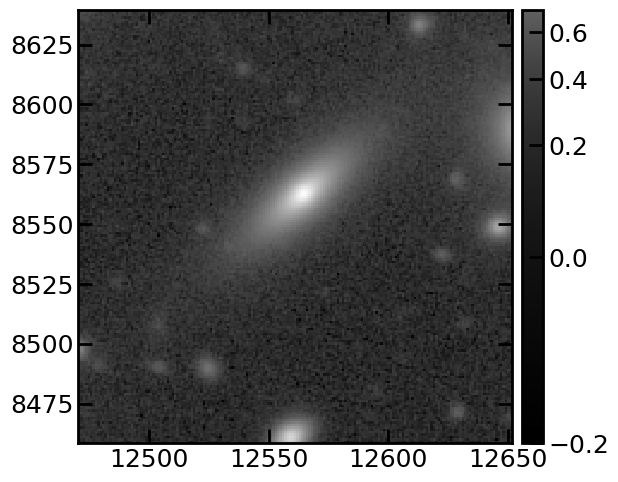

In [16]:
imtype = 'deepCoadd'
test = make_image_cutout(service, ra, dec, dataId=dataId,
                         imtype=imtype, cutout_size=0.005)
plotImage(ExposureF(test))


## 3. Science application: validating a galaxy sample based on color-color selection 

This section will demonstrate a simple example of a science use-case for the Rubin Image Cutout Service. Lyman-break color selections are a common way to identify galaxies at high redshifts. The selections make use of the absorption by intergalactic hydrogen in the foreground of all galaxy light blueward of the Lyman limit (912A) or at very high redshifts, Lyman-alpha (1216A). <a href="http://candels-collaboration.blogspot.com/2012/08/how-to-find-distant-galaxies.html">More details about why this works can be found at this blog-post.</a> DP0.2 includes mock galaxies up to redshift (z) of 3, where the Lyman-break falls between the LSST u and g bands. Such galaxies can be identified by their very red u-g colors, and since intergalactic hydrogen absorbs all the light blueward of the Lyman break, true z~3 galaxies should be undetected in the LSST u-band. The cell below will perform a search for redshift of 3 galaxies as u-band dropouts, and will create cutouts in each of the LSST filters in order to visually inspect the Lyman-break galaxy (LBG) candidates to confirm the real candidates show no u-band flux. 

### 3.1 The u-band dropout LBG color selection
To search for $z\sim3$ LBGs in DP0.2, first define a u-band color selection based on the existing literature that uses filter sets similar to that of LSST. Below outlines the set of colors used in Steidel et al. 2003 (see also Boutsia et al 2014, among other references. Many selections exist, where changes to colors would alter the redshift selection function, or may differ due to differences in the broad band filter shapes of other instruments).

U − G >= (G − R) + 1.0

G − R <= 1.2


where capital letters U, G, and R indicate the total AB magnitudes in the LSST filters u, g, r. Since DP0.2 is only 5-year depth mock data in the LSST filters, our search will also include a g-band magnitude that is relatively bright (G < 24.5 ABmag) in order to obtain high-quality candidates. 

High redshift galaxies are typically small in size. For this exercise, use aperture photometry with a relatively small aperture diameter (9 pixels) in order to obtain high S/N measurements and exclude neighbors.

#### 3.1.1 Ammending a typical search because of the rarity of z~3 galaxies in the mock data.
The mock galaxies that go into DP0.2 are created using the LSST Catalog Simulator (<a href=https://www.lsst.org/scientists/simulations/catsimcatSim>catSim</a>), and are based on an empirical model of the evolution of galaxies outlined in <a href="https://arxiv.org/abs/1907.06530">Korytov et al. 2019</a>. The input model is based on realistic number densities, fluxes, and redshift distributions across cosmic time, and utilizes the UniverseMachine methodology to assign empirical properties (see <a href="https://arxiv.org/abs/1806.07893">Behroozi et al. 2019</a>). 

Typically at any redshift, bright galaxies are rarer than faint galaxies, which are much more common. And typically in any patch of the sky, nearby galaxies will be much more common above the detection limit of a survey than distant $z\sim3$ galaxies. This means that $z\sim3$ galaxies that are bright enough to meet the criteria we want (G$ < 24.5$) will require a large search area to identify a statistical sample. So, in this example, we will first identify a parent sample of bright (G < 24.5) galaxies over a very large area (4 degrees) to ensure the parent sample contains enough rare distant galaxies.



In [17]:
center_coords = "62, -37"
ralbg = 62.
declbg = -37.
radius = "4.0"


In [18]:
max_rec = 500000
query = "SELECT TOP " + str(max_rec) + " " + \
        "objectId, coord_ra, coord_dec, detect_isPrimary, patch, tract, " + \
        "u_ap09Flux, u_ap09FluxErr, " + \
        "scisql_nanojanskyToAbMag(u_ap09Flux) as umag, " + \
        "scisql_nanojanskyToAbMag(r_ap09Flux) as rmag, " + \
        "scisql_nanojanskyToAbMag(g_ap09Flux) as gmag, " + \
        "scisql_nanojanskyToAbMag(u_ap09FluxErr) as umagErr " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + center_coords + ", " + radius + ")) = 1 " + \
        "AND detect_isPrimary = 1 AND detect_fromBlend = 0 " + \
        "AND g_ap09Flux/g_ap09FluxErr > 10 AND " + \
        "r_ap09Flux/r_ap09FluxErr > 10" + \
        "AND scisql_nanojanskyToAbMag(g_ap09Flux) < 24.5 "

results = service.search(query)

results.to_table()

objectId,coord_ra,coord_dec,detect_isPrimary,patch,tract,u_ap09Flux,u_ap09FluxErr,umag,rmag,gmag,umagErr
,deg,deg,,,,nJy,nJy,,,,
int64,float64,float64,bool,int64,int64,float64,float64,float64,float64,float64,float64
1406372128948751548,61.5336891,-40.2858143,True,48,3262,1444.1011663,66.3450074,23.50100595315756,23.862376291528673,23.61050309004312,26.845479382835762
1406372128948752158,61.5158251,-40.2731473,True,48,3262,560.9189933,67.067541,24.527749635197605,21.97788497820341,23.18637070012619,26.833719041428388
1406372128948751780,61.5337686,-40.2814227,True,48,3262,1038.948922,66.014661,23.8585145080051,23.858539168667107,23.788767295964643,26.850899006436556
1406372128948749564,61.5230775,-40.3288598,True,48,3262,268.264292,68.7178734,25.32859282837807,23.072319965199178,24.327118668277322,26.807325722510424
1406372128948749675,61.5152067,-40.3267846,True,48,3262,1063.301136,69.1828566,23.833359305337797,22.54829023328209,23.40376549046746,26.80000377420527
1406372128948753229,61.5304195,-40.2497165,True,48,3262,719.2643606,62.1772048,24.257778645919164,24.3014910829056,24.458223637945373,26.91592201432092
1406372128948753635,61.5251186,-40.2412818,True,48,3262,1384.2811529,60.7587741,23.54693923504427,23.36659975061598,23.641606100270785,26.94097749316929
1406363332855730322,61.6601016,-40.2670642,True,47,3262,766.7137236,62.3207114,24.188416907822596,23.77468357547394,24.0607373794599,26.913418994431034


The next cell will plot the U-G vs G-R colors of the parent sample, and identify the high-redshift galaxy candidates based on the color selection discussed above. For sources with low S/N fluxes in u-band, we cannot robustly recover the U-G color, and instead we get a lower limit on how red it is (owing to the upper limit to the u-band flux). Thus, the U-G color can be overestimated if the u-band flux is not significant. Thus, sources with low S/N u-band flux will be reset to an error floor that corresponds the noise level of the u-band imaging so that it's color is not overestimated. To do this, define a new parameter called `umag` to store the u-band magnitude for assessing colors. In this case, if sources have signal to noise less than 1 in U_band, umag will instead hold the `umagErr` from the object table).

Further, this simple example uses a restricted color selection that is more narrow and blue in G-R than typical selections (G-R$<$0.2; this may exclude real z=3 galaxies that are redder in G-R, for example galaxies that have older stars or are dusty; but the restriction is helpful for this simple example because it lowers the number of interloper sources). The LBG candidates (indexed from the array as `whlbg`) identified using the color selection (black dashed lines) are in orange, with the full query of all objects in blue.


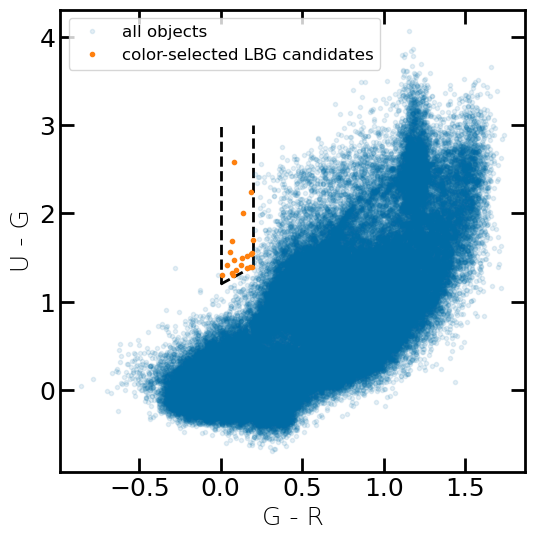

In [19]:
#  here, set u-band magnitude to umag of 1-sigma error before selecting colors
umag = np.zeros(len(results['umag']))
ubandS2N = results['u_ap09Flux'] / results['u_ap09FluxErr']

for i in range(len(umag)):
    whnondet = np.where(ubandS2N[i] < 1)[0]
    if len(whnondet) > 0:
        umag[i] = results['umagErr'][i]
    else:
        umag[i] = results['umag'][i]

GRlim = 0.2
GRfloor = 1.2

whlbg = np.where(((umag-results['gmag'])
                  >= ((results['gmag'] - results['rmag']) + GRfloor))
                 & ((results['gmag'] - results['rmag']) < GRlim)
                 & ((results['gmag'] - results['rmag']) > 0))[0]

# plot the color-color selection box:
GmR = np.arange(0, GRlim + 0.01, 0.1)
plt.plot(GmR, GmR + GRfloor, '--', color='k')
plt.plot([0, 0], [GRfloor, 3], '--', color='k')
plt.plot([GRlim, GRlim], [GRlim + GRfloor, 3], '--', color='k')

GminusR = results['gmag']-results['rmag']
UminusG = umag-results['gmag']

plt.plot(GminusR, UminusG, '.', label='all objects', alpha=.1)
plt.plot(GminusR[whlbg], UminusG[whlbg], '.',
         label='color-selected LBG candidates')

plt.xlabel('G - R')
plt.ylabel('U - G')
plt.legend()
plt.show()


Some fraction of the orange LBG candidates might be interlopers. The cell below will plot image cutouts of each LBG candidate for visual inspection. Since this is a simulated dataset, included in this cell is `query3` to the TAP service, which pulls the intrinsic redshift for each object from the truth table to compare with the expected redshift $z\sim3$ of selected objects (see DP0.2 Tutorial Notebook 08 for more information on truth tables). 

Due to the number of cutouts, this cell can take some time to run. Adjust the range of the for loop as needed to see the cutouts for the entire sample, rather than a subset of 5 (for example, to display the full set of selected LBGs, replace the first line with `for i in range(len(whlbg)):`).

By inspecting the cutouts and intrinsic redshift, there are a small number of interlopers (at redshifts $z<2.5$ or so) which visibly show some u-band flux.

In [ ]:
filt = ["u", "g", "r", "i", "z"]

for i in range(5):
    fig, axs = plt.subplots(1, len(filt), figsize=(25, 25))

    for j, ax in enumerate(fig.axes):
        dataId_deep = {'patch': results['patch'][whlbg][i],
                       'tract': results['tract'][whlbg][i],
                       'band': filt[j]}
        cutout = make_image_cutout(service, results['coord_ra'][whlbg][i],
                                   results['coord_dec'][whlbg][i],
                                   cutout_size=0.001, imtype='deepCoadd',
                                   dataId=dataId_deep,
                                   filename='cutout_' + filt[j] +
                                   '_' + str(i) + '.fits')

        id = str(results['objectId'][whlbg][i])
        query3 = "SELECT mt.id_truth_type AS mt_id_truth_type, " + \
                 "obj.objectId AS obj_objectId,  " + \
                 "ts.redshift AS ts_redshift " + \
                 "FROM dp02_dc2_catalogs.MatchesTruth AS mt " + \
                 "JOIN dp02_dc2_catalogs.TruthSummary AS ts " + \
                 "ON mt.id_truth_type=ts.id_truth_type " + \
                 "JOIN dp02_dc2_catalogs.Object AS obj " + \
                 "ON mt.match_objectId=obj.objectId " + \
                 "WHERE obj.objectId="+id+" " + \
                 "AND ts.truth_type=1 " + \
                 "AND obj.detect_isPrimary=1 "

        results3 = service.search(query3)
        results3.to_table()

        hdulist = fits.open(cutout)
        img_hdr = hdulist[1].header
        img_wcs = WCS(img_hdr)
        img_data = fits.getdata(cutout)
        ax.imshow(img_data, cmap='gray',
                  vmin=0, vmax=0.7, norm='linear',
                  origin='lower')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(.1, .9, filt[j]+'-band z=' + str(results3['ts_redshift'][0]),
                color='white')


## 4. Creating calexp cutouts to inspect changing flux for the diaObject

Another useful application of the cutout tool is to visually inspect a large number of images of a source identified with difference image analysis (DIA) in order to confirm its variability. 

This example is different in that it requires generating cutouts of calexp files around the time the transient is identified, rather than the deepCoadds as used above. 

### 4.1 Query for the source information needed to plot images before and after the transient event

This example will use a known diaObject with ID 1250953961339360185 (one identified and studied in DP0.2 tutorial notebook 07a). The cell below will retrieve the information needed to generate a set of images in order of time, including and after the transient event. The TAP query will identify 8 diaSource IDs measured for this diaObject at the ra/dec, and will also retrieve the ccdVisitId of each time the diaSource was observed in a calexp image.  

The last line will sort the query return by date, so that they appear in the correct chronological order.

In [ ]:
diaObjectId = 1250953961339360185

results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, "
                         "psFlux, psFluxErr, filterName, midPointTai, "
                         "SNR, ccdVisitId, "
                         "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "
                         "FROM dp02_dc2_catalogs.DiaSource "
                         "WHERE diaObjectId = " + str(diaObjectId)
                         + " AND filterName = 'i' "
                         "ORDER BY midPointTai")

diaSrc = results.to_table()
diaSrc

The next cell will retrieve calexp cutouts for each of the dia sources in the query, and plot them. Vmin and vmax set a common scaling so that the image scale is not skewed by a bright neighbor, and emphasizes the lower brightness sources such as the dia source. Each figure also is labeled by the time since the first difference image ($\Delta$t in units MJD).

In [ ]:
%matplotlib inline

ra = diaSrc['ra'][0] 
dec = diaSrc['decl'][0]
vmin = -200
vmax = 300    
i=0
for src in diaSrc:
    ccdvisitID = src['ccdVisitId']
    visit = str(ccdvisitID)[:-3]
    detector = str(ccdvisitID)[-3:]
    visit = int(visit)
    detector = int(detector)

    dataId_calexp = {'visit':visit, 'detector':detector}
    test = make_image_cutout(service, ra, dec, cutout_size=0.007,
                             imtype='calexp', dataId=dataId_calexp,
                             filename='cutout_'+str(i)+'.fits')

    ref_fitsname = 'cutout_'+str(i)+'.fits'
    image_file = os.path.join(os.getenv('HOME'), 'temp/'+ref_fitsname)

    fig, ax1 = plt.subplots(1,1,figsize=(2, 2))

    hdulist = fits.open(image_file)
    img_hdr = hdulist[1].header
    img_wcs = WCS(img_hdr)
    img_data = fits.getdata(image_file)
    ax1.imshow(img_data, cmap='gray', 
               vmin=vmin, vmax=vmax,
               origin='lower')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(.1, .9,'$\Delta$t=' + str(round(src['midPointTai']-diaSrc['midPointTai'][0],3)),
                color='white',fontsize=12)
    plt.show()
    i = i+1


### 4.2 Align the calexp images of the transient

In the above plots, it is clear that the calexp image orientations are not aligned with eachother, because the calexp images are not necessarily all taken in the same position angle on the sky. The cell below will go through each dia source, identify the calexp file in which it was identified, and create cutouts (as above) except now they will all be aligned with eachother. At the same time as creating these new aligned fits files for each cutout, the cell will create png files that will be useful for visualizing the transient behavior (to be used in Section 4.3). (Note: ExposureF creates a known warning that is benign in this circumstance; it originates because the recommended LSST science pipeline version used here, 2024_4, is behind the version used when creating cutouts which is 2024_5. The warning can safely be ignored).


In [ ]:
i = 0
cutout_size_pix = 131

# 0.2-arcsec pixels, convert to degrees
cutout_size = cutout_size_pix * 0.2 / 3600.0

for src in diaSrc:
    ccdvisitID = src['ccdVisitId']
    visit = str(ccdvisitID)[:-3]
    detector = str(ccdvisitID)[-3:]
    visit = int(visit)
    detector = int(detector)
    dataId_calexp = {'visit': visit, 'detector': detector}
    if i == 0:

        # Make the first image the reference image, that all the
        # others images will be warped to align with.
        ref_fitsname = 'cutout_ref.fits'
        ref_cutout = os.path.join(os.getenv('HOME'), 'temp/'+ref_fitsname)

        make_image_cutout(service, ra, dec, cutout_size=cutout_size,
                          imtype='calexp', dataId=dataId_calexp,
                          filename=ref_fitsname)

        img_ref = ExposureF(ref_cutout)
        minmax = get_minmax_xy(img_ref, cutout_size_pix)
        im_arr = img_ref.image.array[minmax['minx']: minmax['maxx'],
                                     minmax['miny']: minmax['maxy']]

        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
        plt.imshow(im_arr, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

        ax.text(.1, .9, r'$\Delta$t='
                + str(round(src['midPointTai']-diaSrc['midPointTai'][0], 2)),
                color='white', fontsize=12)

        figname = os.path.join(os.getenv('HOME'),
                               'temp/cutout_' + str(i) + '.png')
        if os.path.isfile(figname):
            os.remove(figname)
        plt.savefig(figname)
        plt.show()
        plt.close()

    else:

        fitsname = 'cutout_'+str(i)+'.fits'
        make_image_cutout(service, ra, dec, cutout_size=cutout_size,
                          imtype='calexp', dataId=dataId_calexp,
                          filename=fitsname)

        img_cutout = os.path.join(os.getenv('HOME'), 'temp/'+fitsname)
        img = ExposureF(img_cutout)

        img_warped = warp_img(img_ref, img, img_ref.getWcs(), img.getWcs())

        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

        minmax = get_minmax_xy(img_warped, cutout_size_pix)
        im_arr = img_warped.image.array[minmax['minx']: minmax['maxx'],
                                        minmax['miny']: minmax['maxy']]

        plt.imshow(im_arr, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(.1, .9, r'$\Delta$t='
                + str(round(src['midPointTai']-diaSrc['midPointTai'][0], 2)),
                color='white', fontsize=12)

        figname = os.path.join(os.getenv('HOME'),
                               'temp/cutout_' + str(i) + '.png')
        if os.path.isfile(figname):
            os.remove(figname)
        plt.savefig(figname)
        plt.show()
        plt.close()
    i += 1



### 4.3 Make a gif of the aligned calexp cutouts for the transient

The cell below will take all the png files created above in the temp folder, and make a gif movie that demonstrates the transient behavior of the diaobject. The gif is by default stored in the same directory as the images it is generated from. Once that is completed, the second cell below will do the file cleanup, and delete all of the fits, png, and gifs created during this tutorial. To remove the temp folder, close the notebook, open the terminal and cd to the home directory, and type `rmdir temp` from the command line.


In [ ]:

images = os.path.join(os.getenv('HOME'), 'temp/')
make_gif(images)

display(dimg(data=open(images+'animation.gif', 'rb').read()))

In [ ]:
for filepath in glob.glob(os.path.join(os.getenv('HOME'), 'temp/')+"*"):
    os.remove(filepath)

## 5. Exercises for the learner

1) Extend the time baseline for the cutouts of the DIA object prior to the transient detection (hint, use the ForcedSourceOnDiaObject table)
2) Test the failure modes of the cutout tool: what happens if a cutout is requested around coordinates that do not lie inside the linked image?